## Evaporation values


The idea of this work is to obtain Evaporation values from Narrabri river at Namoi.
The data was obtained from the [Bureau of meteorology](http://www.bom.gov.au/climate/data/index.shtml?bookmark=200), which contains monthly climatic data. The data wasn't processed previously, and several parameters to calculate Evapotranspiration aren't included, so some variables were calculated using equations with the data available.
Data was messed, and a previous processing was required. It was obtained in the meteolological station of Narrabri West Post Office, at 212 masl, in the NSW State (Latitude: 30.34 degrees, Longitude: 149.76 degrees).


In [21]:
%matplotlib inline
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pylab



### Evaporation values through the FAO Pennman Monteith equation




Several variables were calculated according to the FAO Irrigation and Drainage Paper N 56, Crop Evapotranspiration (guidelines for computing crop water requirements; Allen et al., 1998), in order to obtain evaporation through the FAO Penman-Monteith equation:

$ ET_0 =\frac{0.408\Delta(R_n-G)+\gamma \frac{900}{T+273} u_2(e_s-e_a)}{\Delta +\gamma (1+0.34u_2)} $

where:
ETo reference evapotranspiration [mm day<sup>-1</sup>], Rn net radiation at the crop surface [MJ m<sup>-2</sup> day<sup>-1</sup>], G soil heat flux density [MJ m<sup>-2</sup> day<sup>-1</sup>], T mean daily air temperature at 2 m height [°C], u<sub>2</sub> wind speed at 2 m height [m s<sup>-1</sup>], e<sub>s</sub> saturation vapour pressure [kPa], e<sub>a</sub> actual vapour pressure [kPa], e<sub>s</sub>-e<sub>a</sub> saturation vapour pressure deficit [kPa], Δ slope vapour pressure curve [kPa °C<sup>-1</sup>], γ psychrometric constant [kPa °C<sup>-1</sup>].

In [3]:
df=pd.read_csv(r'C:\Users\ifue3702\Downloads\Climate Data Narrabri\IDCJCM0037_053030 (2).csv',
              delimiter=',',
              index_col=None,
              header='infer',
              na_values=' ')
dfa=df.drop("Monthly Climate Statistics for 'NARRABRI WEST POST OFFICE' [053030]", 1)
dfb=dfa.dropna()
dfc=dfb.transpose()
dfc.to_csv(r'C:\Users\ifue3702\Downloads\Climate Data Narrabri\prueba.csv')
data=pd.read_csv(r'C:\Users\ifue3702\Downloads\Climate Data Narrabri\prueba.csv',
              delimiter=',',
              index_col=None,
              header='infer',
              na_values=' ',
              skiprows=range(0,1))


Initial data to consider is the altitude of the meteorological station, which is located 212 m.a.s.l. Also, an albedo of 0.23 was considered when doing the calculus of some variables, which implies a grass cover.

In [4]:
masl=212
albedo=0.23

The first variable calculated was the mean temperature, which was obtained through:

$T_{mean}=\frac{T_{max} + T_{min}}{2}$

where T<sub>max</sub> and T<sub>min</sub> are the mean maxim and minimum temperatures of the dataframe for each month.

In [5]:
#list(data.columns.values)
#Add mean temperature = (Tmax+tmin)/2 in Celcius degrees
data['Mean_T']=((data['Mean maximum temperature (Degrees C) for years 1962 to 2002 ']+data['Mean minimum temperature (Degrees C) for years 1962 to 2002 '])/2)


Mean wind speed was assumed measured at a high of 2 m , calculated through the mean of wind speeds at 9 am and 3 pm, and converted to m s<sup>-1</sup>:

In [6]:
#add mean wind speed in m per second, supossedly at 2 m heigth 
data['Mean_wind_speed_']=((data['Mean 9am wind speed (km/h) for years 1962 to 2002 ']+data['Mean 3pm wind speed (km/h) for years 1962 to 2002 '])/2)*1000/3600

The maximum and minimum e<sup>o</sup> (saturation vapour pressure) were calculated through:

$e^o(T) = 0.6108exp[\frac{17.27T}{T+237.3}]$

where T corresponds to the mean temperature. This way e<sub>s</sub> was calculated as:

$e_s = \frac{e^o(T_{max}) + e^o(T_{min})}{2}$

In [7]:
data['e0_min']=0.6108*(2.71828**((17.27*data['Mean 9am temperature (Degrees C) for years 1962 to 2002 '])/(data['Mean 9am temperature (Degrees C) for years 1962 to 2002 ']+237.3)))
data['e0_max']=0.6108*2.71828**((17.27*data['Mean 3pm temperature (Degrees C) for years 1962 to 2002 '])/(data['Mean 3pm temperature (Degrees C) for years 1962 to 2002 ']+237.3))
data['es']=(data['e0_min']+data['e0_max'])/2


In the case of the actual vapour pressure (e<sub>a</sub>) values, these were calculated through the saturation vapor pressures (e<sup>o</sup>) and the relative humidity:

$RH = 100\frac{e_a}{e^o(T)}$
    
The actual vapour pressure was then averaged and the vapour presure deficit was calculated by substracting e<sub>a</sub> to e<sub>s</sub>.
    

In [8]:
data['ea_min']=(data['Mean 9am relative humidity (%) for years 1962 to 2002 ']*data['e0_min'])/100
data['ea_max']=(data['Mean 3pm relative humidity (%) for years 1962 to 2002 ']*data['e0_max'])/100
data['ea']=(data['ea_min']+data['ea_max'])/2
data['es_ea']=(data['es']-data['ea'])


The slope of the saturation vapour pressure curve was calculated as:

$\Delta = \frac{4098[0.6108exp(\frac{17.27T}{T+237.3})]}{(T+237.3)^2}$

where T is the mean temperature in celsius degrees.

In [9]:
data['delta']=(4098*(0.6108*np.exp((17.27*data['Mean_T'])/(data['Mean_T']+237.3))))/(data['Mean_T']+237.3)**2

Pressure in kPa was calculated through the elevation value of the meteorological station in meters through the following equation.

$P=101.3(\frac{293 - 0.0065z}{293})^{5.26}$

This value enter as an input in the calculation of the psychrometric constant (γ):

$\gamma = 0.665 * 10^{-3} P$

In [10]:
data['pressure']=101.3*((293-0.0065*masl)/293)**5.26
data['psi']=data['pressure']*0.665*10**(-3)


It was assumed that the 'Mean daily solar exposure (MJ m<sup>-2</sup>)' corresponded to the solar or shortwave radiation (R<sub>s</sub>). Thus, the net solar radiation (R<sub>ns</sub>) was calculated as:

$R_{ns} = (1 - \alpha)R_s$

In [11]:
data['Rns']=(1-albedo)*data['Mean daily solar exposure (MJ/(m*m)) for years 1990 to 2016 ']


In the case of the extraterrestrial radiation for daily periods (R<sub>a</sub>), it was calculated by a formula of Hargreaves, which is adjusted and validated at several weather stations in a variety of climatic conditions:

$R_s= ^kRs\sqrt{(T_{max}-T_{min})}R_a$

where <sup>k</sup>Rs corresponds to an adjustement coefficient from 0.16 to 0.19, being 0.16 a value used when land mass dominates and air masses are not strongly influenced by large water bodies, and 0.19 is associated to coastal locations, where air masses are influenced by the ocean. In this case, a <sup>k</sup>Rs value of 0.165 was used due to the location of Narrabri.

In [12]:
data['Ra']=data['Mean daily solar exposure (MJ/(m*m)) for years 1990 to 2016 ']/(0.165*(data['Mean maximum temperature (Degrees C) for years 1962 to 2002 ']-data['Mean minimum temperature (Degrees C) for years 1962 to 2002 '])**0.5)

Clear sky solar radiation (R<sub>so</sub>) was then calculated through elevation and R<sub>a</sub> values as:

$R_{so} = (0.75+2*10^{-0.5}z)R_a$   

In [13]:
data['Rso']=(0.75+2*0.00001*212)*data['Ra']

Net longwave radiation (R<sub>nl</sub>) was obtained by using the temperature values in Kelvin degrees, radiation parameters, and the actual vapour pressure:

$R_{nl}=\sigma[\frac{T_{max,K}^4+T_{min,K}^4}{2}](0.34-0.14\sqrt{e_a})(1.35\frac{R_s}{R_{so}}-0.35)$

In [14]:
data['Rnl']=4.903*10**(-9)*(((data['Mean maximum temperature (Degrees C) for years 1962 to 2002 ']+273.16)**4+(data['Mean minimum temperature (Degrees C) for years 1962 to 2002 ']+273.16)**4)/2)*(0.34-0.14*data['ea']**0.5)*(1.35*(data['Mean daily solar exposure (MJ/(m*m)) for years 1990 to 2016 ']/data['Rso'])-0.35)

Net Radiation was then calculated as the substraction of the incoming net shortwave radiation (R<sub>ns</sub>) and the net longwave radiation (R<sub>nl</sub>).

In [15]:
data['Rn']=data['Rns']-data['Rnl']

The soil heat flux was calculated in a monthly base with the following equation:

$G_{month,i} = 0.07(T_{month,i+1}-T_{month,i-1})$

In [17]:
#def obtaining_G ():
#for row in data['Rns']:
#   if row in data.['Rns'] > 11:
#data['G']
#        return row%11
#  return data['G']
data['G']=0
#data['G'][0]=(data['Rns'][1]-data['Rns'][11])*0.07#data['G']=0.07*R
#figure out how to improve this code, is annoying!!!
data.set_value(0, ['G'], (data['Rns'][1]-data['Rns'][11])*0.07)
data.set_value(1, ['G'], (data['Rns'][2]-data['Rns'][0])*0.07)
data.set_value(2, ['G'], (data['Rns'][3]-data['Rns'][1])*0.07)
data.set_value(3, ['G'], (data['Rns'][4]-data['Rns'][2])*0.07)
data.set_value(4, ['G'], (data['Rns'][5]-data['Rns'][3])*0.07)
data.set_value(5, ['G'], (data['Rns'][6]-data['Rns'][4])*0.07)
data.set_value(6, ['G'], (data['Rns'][7]-data['Rns'][5])*0.07)
data.set_value(7, ['G'], (data['Rns'][8]-data['Rns'][6])*0.07)
data.set_value(8, ['G'], (data['Rns'][9]-data['Rns'][7])*0.07)
data.set_value(9, ['G'], (data['Rns'][10]-data['Rns'][8])*0.07)
data.set_value(10, ['G'], (data['Rns'][11]-data['Rns'][9])*0.07)
data.set_value(11, ['G'], (data['Rns'][0]-data['Rns'][10])*0.07)

,Statistic Element,Mean maximum temperature (Degrees C) for years 1962 to 2002,Highest temperature (Degrees C) for years 1962 to 2002,Lowest maximum temperature (Degrees C) for years 1962 to 2002,Mean number of days >= 30 Degrees C for years 1962 to 2002,Mean number of days >= 35 Degrees C for years 1962 to 2002,Mean number of days >= 40 Degrees C for years 1962 to 2002,Mean minimum temperature (Degrees C) for years 1962 to 2002,Lowest temperature (Degrees C) for years 1962 to 2002,Highest minimum temperature (Degrees C) for years 1962 to 2002,...,es_ea,delta,pressure,psi,Rns,Ra,Rso,Rnl,Rn,G
0,January,33.8,43.4,20.2,26.4,13.1,1.3,19.3,10.6,28.3,...,2.154700e+00,0.204397,98.819,0.065715,20.559,42.495536,32.051833,4.502854e+00,1.605615e+01,-0.14553
1,February,33.2,42.3,17.9,24.0,9.2,0.4,19.1,7.8,27.4,...,1.964816e+00,0.200239,98.819,0.065715,18.557,38.897666,29.338176,4.357752e+00,1.419925e+01,-0.30184
2,March,31.2,40.6,18.9,21.8,3.6,0.1,16.4,5.6,24.7,...,1.810161e+00,0.177226,98.819,0.065715,16.247,33.240508,25.071321,4.706585e+00,1.154041e+01,-0.40425
3,April,27.3,37.2,14.0,5.8,0.1,0.0,11.9,0.7,21.0,...,1.367026e+00,0.141635,98.819,0.065715,12.782,25.636798,19.336299,5.034131e+00,7.747869e+00,-0.44198
4,May,22.5,31.3,11.7,0.1,0.0,0.0,8.3,-2.2,19.8,...,8.201572e-01,0.112290,98.819,0.065715,9.933,20.747300,15.648444,4.811598e+00,5.121402e+00,-0.32340
5,June,18.7,26.9,9.4,0.0,0.0,0.0,5.2,-5.6,15.2,...,5.878856e-01,0.092213,98.819,0.065715,8.162,17.484573,13.187565,4.720565e+00,3.441435e+00,-0.06468
6,July,18.0,26.7,7.8,0.0,0.0,0.0,3.7,-4.4,16.4,...,5.860501e-01,0.086493,98.819,0.065715,9.009,18.751409,14.143062,5.021955e+00,3.987045e+00,0.24255
7,August,19.8,32.1,10.4,0.1,0.0,0.0,4.6,-3.9,17.6,...,8.132853e-01,0.093557,98.819,0.065715,11.627,23.473141,17.704382,5.349634e+00,6.277366e+00,0.39886
8,September,23.4,36.6,11.1,1.7,0.1,0.0,7.6,-1.7,21.1,...,1.150522e+00,0.112923,98.819,0.065715,14.707,29.121979,21.964961,5.408145e+00,9.298855e+00,0.42042
9,October,27.1,40.7,14.4,8.0,0.9,0.0,11.7,-0.6,24.7,...,1.564703e+00,0.140103,98.819,0.065715,17.633,35.366426,26.674773,5.276545e+00,1.235646e+01,0.31801


Finally evaporation (mm d<sup>-1</sup>) was calculated by the FAO Pennman Monteith equation, and a plot was created to show the evaporation values of each month:

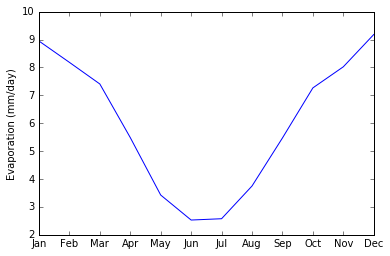

In [23]:
data['ET0']=(0.408*data['delta']*(data['Rn']-data['G'])+data['psi']*900/(data['Mean_T']+273)*data['Mean_wind_speed_']*data['es_ea'])/(data['delta']+data['psi']*(1+0.34*data['Mean_wind_speed_']))
clean=data[0:13]#delete not used data

#plotting Evaporation against months
Months=['Jan', 
        'Feb', 
        'Mar', 
        'Apr', 
        'May', 
        'Jun', 
        'Jul', 
        'Aug', 
        'Sep', 
        'Oct', 
        'Nov', 
        'Dec'] #creates list of months

yep=np.array(list(clean['ET0'][0:12])) #convert selected data of column ET to array
xep=np.array(range(1,13)) #define a range of values to stick at the x (strings) variable
plt.xticks(xep, Months) #sticks string to numbers in the x axis to plot, 
plt.plot(xep,yep)
plt.ylabel('Evaporation (mm/day)')
plt.show()

## Evaporation from open water sources

The problem is that ET obtained by the previous method was formulated for crop irrigation calculus, and coresponds to soil evapotranspiration, but in the present case the approach is refered to open water sources, such as dams or ponds, whose equations are slightly different.
For that reason, the equation mentioned in the Handbook of Hydrology, chapter 4.4.4 (Maidment et al., 1990) was used:

$E_p=F^1_pA+F^2_p\bar{D }$


assuming that the water is stagnant, without inputs and outputs to the system.
Being that the case, for each month different water temperatures were assessed, obtaining different evaporation values depending on the water temperature (from 0 to 30 Celsius degrees), and the range of values was higher the higher the evaporation values, up to approximately 0.36 mm/day in december. 


In this case, the climatic variables change a litle because of the necessity to consider the water temperature as well. Thus the lambda value (MJ kg<sup>-1</sup>) changes its formulae compared to other methods, being:

$\lambda = 2.501 - 0.002361 T_s$

where T<sub>s</sub> corresponds to the surface temperature of water.
As water involved in calculations was considered being stangnant, without inputs and outputs, the A value in the equation is equaled to R<sub>n</sub> obtained in the previous method.



In [24]:
#Calculating evaporation from open water surfaces

#january... iteration for every month, there must be a easier way to do this, but there are so many variables involved that I just used the simplier way 

Lamb=[] #define list to add Lamda values
water_temp=range(0,31) #list with water temperatures from 0 to 30°C
def Lambda (water_temp):
    #function to obtain lambda at different water temperatures 
    water_temp=range(0,31)
    for num in water_temp:
        a=2.501-0.002361*num
        Lamb.append(a)
        
Lambda(water_temp) #run function and fill the Lambda function

A=[clean['Rn'][0]/x for x in Lamb] #transforms Rn from MJ m-2 to mm d-1 by dividing by Lambda


In the case of $\bar{D}$, it represents the vapor pressure deficit calculated in the previous method as e<sub>s</sub>-e<sub>a</sub>.
The psychrometric constant (kPa <sup>o</sup>C<sup>-1</sup>) also changes because in this case considers the temperature of water, which is implied in the $\lambda$ value:

$\gamma = 0.0016286\frac{P}{\lambda}$

In [26]:
psi_water=[] #create empy list of psi
def psi (Lambda): #function to calculate Psi depending on Lambda
    for num in Lamb:
        b=0.0016286*(101.3*((293-0.0065*212)/293)**5.26)/num
        psi_water.append(b)

psi(Lamb) #Run the function and fill the list with calculated values of Psi

The $F^1_p$ value is then calculated as:
$F^1_p = \frac{\Delta}{\Delta+\gamma}$


In [27]:
FPuno_jan=[] #create list for F1 for January
def FP1_jan (psi_water): #define function to calculate F1 depending on psi
    for num in psi_water:
        c=clean['delta'][0]/(clean['delta'][0]+num)
        FPuno_jan.append(c)
        
FP1_jan(psi_water) #fill the list with the calculated values by runing the function



For the other hand, the $F^2_p$ value was calculated through the following equation:

$F^2_p = (\frac{\gamma}{\Delta + \gamma})\frac{6.43(1+0.536 u_2)}{\lambda}$

where u<sub>2</sub> corresponds to the mean wind speed at 2 m.


In [28]:
from __future__ import division #bring zip to the script
#obtaining Fp2, consider that maths in lists cannot be executes so easily
va=[clean['delta'][0]+x for x in psi_water]
vb=[x/y for x, y in zip(psi_water, va)]
bb=list(((clean['Mean_wind_speed_'][0]*0.536 + 1)*6.43)/x for x in Lamb)
FP2_jan=[x*y for x, y in zip(vb, bb)]

#obtaining evaporation values depending on water t°
water_evap_j=[x*y for x,y in zip (FPuno_jan,A)] 
water_evap_jan= [x*clean['es_ea'][0] for x in FP2_jan]
water_evap_january=[x+y for x,y in zip(water_evap_j, water_evap_jan)]

The same calculus was done for each month (probably there must be a more efficient way to do this).

In [29]:
#february

A_feb=[clean['Rn'][1]/x for x in Lamb] #transforms Rn from MJ m-2 to mm d-1 by dividing by Lambda

FPuno_feb=[] #create list for F1 for February
def FP1_feb (psi_water): #define function to calculate F1 depending on psi
    for num in psi_water:
        c=clean['delta'][1]/(clean['delta'][1]+num)
        FPuno_feb.append(c)
        
FP1_feb(psi_water) #fill the list with the calculated values by runing the function

from __future__ import division #bring zip to the script
#obtaining Fp2, consider that maths in lists cannot be executes so easily
va_feb=[clean['delta'][1]+x for x in psi_water]
vb_feb=[x/y for x, y in zip(psi_water, va_feb)]
bb_feb=list(((clean['Mean_wind_speed_'][1]*0.536 + 1)*6.43)/x for x in Lamb)
FP2_feb=[x*y for x, y in zip(vb_feb, bb_feb)]

#obtaining evaporation values depending on water t°
water_evap_f=[x*y for x,y in zip (FPuno_feb,A_feb)] 
water_evap_feb= [x*clean['es_ea'][1] for x in FP2_feb]
water_evap_february=[x+y for x,y in zip(water_evap_f, water_evap_feb)]


#march

A_march=[clean['Rn'][2]/x for x in Lamb] #transforms Rn from MJ m-2 to mm d-1 by dividing by Lambda

FPuno_march=[] #create list for F1 for march
def FP1_march (psi_water): #define function to calculate F1 depending on psi
    for num in psi_water:
        c=clean['delta'][2]/(clean['delta'][2]+num)
        FPuno_march.append(c)
        
FP1_march(psi_water) #fill the list with the calculated values by runing the function

from __future__ import division #bring zip to the script
#obtaining Fp2, consider that maths in lists cannot be executed so easily
va_march=[clean['delta'][2]+x for x in psi_water]
vb_march=[x/y for x, y in zip(psi_water, va_march)]
bb_march=list(((clean['Mean_wind_speed_'][2]*0.536 + 1)*6.43)/x for x in Lamb)
FP2_march=[x*y for x, y in zip(vb_march, bb_march)]

#obtaining evaporation values depending on water t°
water_evap_m=[x*y for x,y in zip (FPuno_march,A_march)] 
water_evap_mar= [x*clean['es_ea'][2] for x in FP2_march]
water_evap_march=[x+y for x,y in zip(water_evap_m, water_evap_mar)]


#april

A_apr=[clean['Rn'][3]/x for x in Lamb] #transforms Rn from MJ m-2 to mm d-1 by dividing by Lambda

FPuno_apr=[] #create list for F1 for april
def FP1_apr (psi_water): #define function to calculate F1 depending on psi
    for num in psi_water:
        c=clean['delta'][3]/(clean['delta'][3]+num)
        FPuno_apr.append(c)
        
FP1_apr(psi_water) #fill the list with the calculated values by runing the function

from __future__ import division #bring zip to the script
#obtaining Fp2, consider that maths in lists cannot be executed so easily
va_apr=[clean['delta'][3]+x for x in psi_water]
vb_apr=[x/y for x, y in zip(psi_water, va_apr)]
bb_apr=list(((clean['Mean_wind_speed_'][3]*0.536 + 1)*6.43)/x for x in Lamb)
FP2_apr=[x*y for x, y in zip(vb_apr, bb_apr)]

#obtaining evaporation values depending on water t°
water_evap_a=[x*y for x,y in zip (FPuno_apr,A_apr)] 
water_evap_apr= [x*clean['es_ea'][3] for x in FP2_apr]
water_evap_april=[x+y for x,y in zip(water_evap_a, water_evap_apr)]

#may

A_may=[clean['Rn'][4]/x for x in Lamb] #transforms Rn from MJ m-2 to mm d-1 by dividing by Lambda

FPuno_may=[] #create list for F1 for april
def FP1_may (psi_water): #define function to calculate F1 depending on psi
    for num in psi_water:
        c=clean['delta'][4]/(clean['delta'][4]+num)
        FPuno_may.append(c)
        
FP1_may(psi_water) #fill the list with the calculated values by runing the function

from __future__ import division #bring zip to the script
#obtaining Fp2, consider that maths in lists cannot be executed so easily
va_may=[clean['delta'][4]+x for x in psi_water]
vb_may=[x/y for x, y in zip(psi_water, va_may)]
bb_may=list(((clean['Mean_wind_speed_'][4]*0.536 + 1)*6.43)/x for x in Lamb)
FP2_may=[x*y for x, y in zip(vb_may, bb_may)]

#obtaining evaporation values depending on water t°
water_evap_m=[x*y for x,y in zip (FPuno_may,A_may)] 
water_evap_ma= [x*clean['es_ea'][4] for x in FP2_may]
water_evap_may=[x+y for x,y in zip(water_evap_m, water_evap_ma)]


#june

A_jun=[clean['Rn'][5]/x for x in Lamb] #transforms Rn from MJ m-2 to mm d-1 by dividing by Lambda

FPuno_jun=[] #create list for F1 for june
def FP1_jun (psi_water): #define function to calculate F1 depending on psi
    for num in psi_water:
        c=clean['delta'][5]/(clean['delta'][5]+num)
        FPuno_jun.append(c)
        
FP1_jun(psi_water) #fill the list with the calculated values by runing the function

from __future__ import division #bring zip to the script
#obtaining Fp2, consider that maths in lists cannot be executed so easily
va_jun=[clean['delta'][5]+x for x in psi_water]
vb_jun=[x/y for x, y in zip(psi_water, va_jun)]
bb_jun=list(((clean['Mean_wind_speed_'][5]*0.536 + 1)*6.43)/x for x in Lamb)
FP2_jun=[x*y for x, y in zip(vb_jun, bb_jun)]

#obtaining evaporation values depending on water t°
water_evap_j=[x*y for x,y in zip (FPuno_jun,A_jun)] 
water_evap_ju= [x*clean['es_ea'][5] for x in FP2_jun]
water_evap_june=[x+y for x,y in zip(water_evap_j, water_evap_ju)]


#july

A_jul=[clean['Rn'][6]/x for x in Lamb] #transforms Rn from MJ m-2 to mm d-1 by dividing by Lambda

FPuno_jul=[] #create list for F1 for july
def FP1_jul (psi_water): #define function to calculate F1 depending on psi
    for num in psi_water:
        c=clean['delta'][6]/(clean['delta'][6]+num)
        FPuno_jul.append(c)
        
FP1_jul(psi_water) #fill the list with the calculated values by runing the function

from __future__ import division #bring zip to the script
#obtaining Fp2, consider that maths in lists cannot be executed so easily
va_jul=[clean['delta'][6]+x for x in psi_water]
vb_jul=[x/y for x, y in zip(psi_water, va_jul)]
bb_jul=list(((clean['Mean_wind_speed_'][6]*0.536 + 1)*6.43)/x for x in Lamb)
FP2_jul=[x*y for x, y in zip(vb_jul, bb_jul)]

#obtaining evaporation values depending on water t°
water_evap_jul=[x*y for x,y in zip (FPuno_jul,A_jul)] 
water_evap_july= [x*clean['es_ea'][6] for x in FP2_jul]
water_evap_julys=[x+y for x,y in zip(water_evap_jul, water_evap_july)]


#August

A_aug=[clean['Rn'][7]/x for x in Lamb] #transforms Rn from MJ m-2 to mm d-1 by dividing by Lambda

FPuno_aug=[] #create list for F1 for august
def FP1_aug (psi_water): #define function to calculate F1 depending on psi
    for num in psi_water:
        c=clean['delta'][7]/(clean['delta'][7]+num)
        FPuno_aug.append(c)
        
FP1_aug(psi_water) #fill the list with the calculated values by runing the function

from __future__ import division #bring zip to the script
#obtaining Fp2, consider that maths in lists cannot be executed so easily
va_aug=[clean['delta'][7]+x for x in psi_water]
vb_aug=[x/y for x, y in zip(psi_water, va_aug)]
bb_aug=list(((clean['Mean_wind_speed_'][7]*0.536 + 1)*6.43)/x for x in Lamb)
FP2_aug=[x*y for x, y in zip(vb_aug, bb_aug)]

#obtaining evaporation values depending on water t°
water_evap_au=[x*y for x,y in zip (FPuno_aug,A_aug)] 
water_evap_aug= [x*clean['es_ea'][7] for x in FP2_aug]
water_evap_august=[x+y for x,y in zip(water_evap_aug, water_evap_au)]


#September

A_sep=[clean['Rn'][8]/x for x in Lamb] #transforms Rn from MJ m-2 to mm d-1 by dividing by Lambda

FPuno_sep=[] #create list for F1 for September
def FP1_sep (psi_water): #define function to calculate F1 depending on psi
    for num in psi_water:
        c=clean['delta'][8]/(clean['delta'][8]+num)
        FPuno_sep.append(c)
        
FP1_sep(psi_water) #fill the list with the calculated values by runing the function

from __future__ import division #bring zip to the script
#obtaining Fp2, consider that maths in lists cannot be executed so easily
va_sep=[clean['delta'][8]+x for x in psi_water]
vb_sep=[x/y for x, y in zip(psi_water, va_sep)]
bb_sep=list(((clean['Mean_wind_speed_'][8]*0.536 + 1)*6.43)/x for x in Lamb)
FP2_sep=[x*y for x, y in zip(vb_sep, bb_sep)]

#obtaining evaporation values depending on water t°
water_evap_s=[x*y for x,y in zip (FPuno_sep,A_sep)] 
water_evap_se= [x*clean['es_ea'][8] for x in FP2_sep]
water_evap_sep=[x+y for x,y in zip(water_evap_s, water_evap_se)]


#October

A_oct=[clean['Rn'][9]/x for x in Lamb] #transforms Rn from MJ m-2 to mm d-1 by dividing by Lambda

FPuno_oct=[] #create list for F1 for October
def FP1_oct (psi_water): #define function to calculate F1 depending on psi
    for num in psi_water:
        c=clean['delta'][9]/(clean['delta'][9]+num)
        FPuno_oct.append(c)
        
FP1_oct(psi_water) #fill the list with the calculated values by runing the function

from __future__ import division #bring zip to the script
#obtaining Fp2, consider that maths in lists cannot be executed so easily
va_oct=[clean['delta'][9]+x for x in psi_water]
vb_oct=[x/y for x, y in zip(psi_water, va_oct)]
bb_oct=list(((clean['Mean_wind_speed_'][9]*0.536 + 1)*6.43)/x for x in Lamb)
FP2_oct=[x*y for x, y in zip(vb_oct, bb_oct)]

#obtaining evaporation values depending on water t°
water_evap_o=[x*y for x,y in zip (FPuno_oct,A_oct)] 
water_evap_oc= [x*clean['es_ea'][9] for x in FP2_oct]
water_evap_oct=[x+y for x,y in zip(water_evap_o, water_evap_oc)]


#November

A_nov=[clean['Rn'][10]/x for x in Lamb] #transforms Rn from MJ m-2 to mm d-1 by dividing by Lambda

FPuno_nov=[] #create list for F1 for October
def FP1_nov (psi_water): #define function to calculate F1 depending on psi
    for num in psi_water:
        c=clean['delta'][10]/(clean['delta'][10]+num)
        FPuno_nov.append(c)
        
FP1_nov(psi_water) #fill the list with the calculated values by runing the function

from __future__ import division #bring zip to the script
#obtaining Fp2, consider that maths in lists cannot be executed so easily
va_nov=[clean['delta'][10]+x for x in psi_water]
vb_nov=[x/y for x, y in zip(psi_water, va_nov)]
bb_nov=list(((clean['Mean_wind_speed_'][10]*0.536 + 1)*6.43)/x for x in Lamb)
FP2_nov=[x*y for x, y in zip(vb_nov, bb_nov)]

#obtaining evaporation values depending on water t°
water_evap_n=[x*y for x,y in zip (FPuno_nov,A_nov)] 
water_evap_no= [x*clean['es_ea'][10] for x in FP2_nov]
water_evap_nov=[x+y for x,y in zip(water_evap_n, water_evap_no)]


#december

A_dec=[clean['Rn'][10]/x for x in Lamb] #transforms Rn from MJ m-2 to mm d-1 by dividing by Lambda

FPuno_dec=[] #create list for F1 for December
def FP1_dec (psi_water): #define function to calculate F1 depending on psi
    for num in psi_water:
        c=clean['delta'][11]/(clean['delta'][11]+num)
        FPuno_dec.append(c)
        
FP1_dec(psi_water) #fill the list with the calculated values by runing the function

from __future__ import division #bring zip to the script
#obtaining Fp2, consider that maths in lists cannot be executed so easily
va_dec=[clean['delta'][11]+x for x in psi_water]
vb_dec=[x/y for x, y in zip(psi_water, va_dec)]
bb_dec=list(((clean['Mean_wind_speed_'][11]*0.536 + 1)*6.43)/x for x in Lamb)
FP2_dec=[x*y for x, y in zip(vb_dec, bb_dec)]

#obtaining evaporation values depending on water t°
water_evap_d=[x*y for x,y in zip (FPuno_dec,A_dec)] 
water_evap_de= [x*clean['es_ea'][11] for x in FP2_dec]
water_evap_dec=[x+y for x,y in zip(water_evap_d, water_evap_de)]







When water temperature is equal to the air temperature, the results would be:

In [12]:
clean['Lambda']=2.501-0.002361*clean['Mean_T']
clean['psi_lamda']=0.0016286*clean['pressure']/clean['Lambda']
clean['A']=clean['Rn']/clean['Lambda']
clean['FP_one']=clean['delta']/(clean['delta']+clean['psi_lamda'])
clean['FP_two']=(clean['psi_lamda']/(clean['psi_lamda']+clean['delta'])*6.43*(1+0.536*clean['Mean_wind_speed_'])/clean['Lambda'])
clean['Eva_water']=(clean['A']*clean['FP_one']+clean['FP_two']*clean['es_ea'])
clean['Eva_water']

0      9.875123
1      8.977944
2      8.042967
3      5.913934
4      3.758186
5      2.832746
6      2.983057
7      4.407028
8      6.438415
9      8.400542
10     9.167643
11    10.276343
12     6.505073
Name: Eva_water, dtype: float64

### Plot T<sup>o</sup> v/s Evaporation
A plot was created showing how the water temperature would affect the evaporation rate for each month. This relationship is linear.

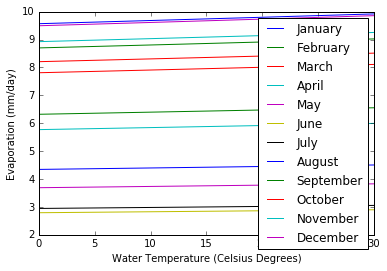

'\nfor c in water_evap:\n    x=\'a\'\n    x=plt.plot(water_evap[c], label= "%s" % c)\n    chr(x=ord(x)+1)\nplt.legend()\nplt.show()'

In [31]:

from collections import OrderedDict #in order to maintain the columns order (doesn't worked)
data=OrderedDict({ 
    'January': water_evap_january, 
    'February': water_evap_february,
    'March': water_evap_march,
    'April': water_evap_april,
    'May': water_evap_may,
    'June': water_evap_june,
    'July': water_evap_julys,
    'August': water_evap_august,
    'September': water_evap_sep,
    'October': water_evap_oct,
    'November': water_evap_nov,
    'December': water_evap_dec}) #creating a dictionary to transform to dataframe

water_evap=pd.DataFrame(data,
                        index= water_temp,
                        columns=data.keys()
                        ) #create a dataframe, the problem is that I couldn't maintain the same order of columns 


#water_evap.plot(); plt.legend([January, February, March, April, May, June, July, August, September, October, November, December], ['January','February','March','April','May','June','July','August','September','October','November','December'])

#plotting evaporation series versus water temperature. This way I could give the order I wanted to the series in the legend 
a=plt.plot(water_evap.index,water_evap['January'], label='January')
b=plt.plot(water_evap.index,water_evap['February'], label='February')
c=plt.plot(water_evap.index,water_evap['March'], label='March')
d=plt.plot(water_evap.index,water_evap['April'], label='April')
e=plt.plot(water_evap.index,water_evap['May'], label='May')
f=plt.plot(water_evap.index,water_evap['June'], label='June')
g=plt.plot(water_evap.index,water_evap['July'], label='July')
h=plt.plot(water_evap.index,water_evap['August'], label='August')
i=plt.plot(water_evap.index,water_evap['September'], label='September')
j=plt.plot(water_evap.index,water_evap['October'], label='October')
k=plt.plot(water_evap.index,water_evap['November'], label='November')
l=plt.plot(water_evap.index,water_evap['December'], label='December')
plt.legend()
plt.xlabel('Water Temperature (Celsius Degrees)')
plt.ylabel('Evaporation (mm/day)')
plt.show()


'''
for c in water_evap:
    x='a'
    x=plt.plot(water_evap[c], label= "%s" % c)
    chr(x=ord(x)+1)
plt.legend()
plt.show()'''
#I tried with a loop, by changing the variables name, but I coudn't because by assigning plots to variables, then they changed from strings.
    




### Basic statistics of the data

In [33]:
water_evap.describe() #returns a summary of the dataframe


,November,September,October,January,April,May,February,August,December,March,July,June
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,9.086227,6.435198,8.356403,9.739657,5.880268,3.756743,8.857889,4.422255,9.671723,7.955789,2.998342,2.843798
std,0.099736,0.070729,0.092626,0.106103,0.067518,0.041958,0.097474,0.048127,0.109498,0.090112,0.032961,0.032143
min,8.923424,6.319728,8.205203,9.566468,5.770074,3.688247,8.698792,4.343673,9.493025,7.808724,2.944525,2.791323
25%,9.003684,6.376664,8.279744,9.651844,5.824387,3.722018,8.777215,4.382428,9.581094,7.881206,2.971066,2.817197
50%,9.085262,6.434524,8.355508,9.738627,5.879605,3.756340,8.856938,4.421802,9.670641,7.954902,2.998032,2.843491
75%,9.168204,6.493336,8.432536,9.826866,5.935760,3.791231,8.938003,4.461817,9.761716,8.029850,3.025437,2.870219
max,9.252528,6.553114,8.510846,9.916580,5.992866,3.826698,9.020431,4.502481,9.854341,8.106072,3.053286,2.897387


### The range of water evaporation each month is:

In [34]:
for c in water_evap:
    print('%s range is: %r' % (c, water_evap[c].max()-water_evap[c].min()))
    
#returns the range of each month

November range is: 0.32910437708491358
September range is: 0.23338608535311689
October range is: 0.30564308406730589
January range is: 0.35011198088162487
April range is: 0.2227914529106565
May range is: 0.13845106083161696
February range is: 0.3216398119133892
August range is: 0.1588076463982766
December range is: 0.36131636635308517
March range is: 0.29734718371663327
July range is: 0.10876149030164672
June range is: 0.10606435574000495


In [35]:
list(clean.columns.values) #returns the column names in clean datadrame

['Statistic Element',
 'Mean maximum temperature (Degrees C) for years 1962 to 2002 ',
 'Highest temperature (Degrees C) for years 1962 to 2002 ',
 'Lowest maximum temperature (Degrees C) for years 1962 to 2002 ',
 'Mean number of days >= 30 Degrees C for years 1962 to 2002 ',
 'Mean number of days >= 35 Degrees C for years 1962 to 2002 ',
 'Mean number of days >= 40 Degrees C for years 1962 to 2002 ',
 'Mean minimum temperature (Degrees C) for years 1962 to 2002 ',
 'Lowest temperature (Degrees C) for years 1962 to 2002 ',
 'Highest minimum temperature (Degrees C) for years 1962 to 2002 ',
 'Mean number of days <= 2 Degrees C for years 1962 to 2002 ',
 'Mean number of days <= 0 Degrees C for years 1962 to 2002 ',
 'Mean rainfall (mm) for years 1891 to 2016 ',
 'Highest rainfall (mm) for years 1891 to 2016 ',
 'Lowest rainfall (mm) for years 1891 to 2016 ',
 'Decile 1 monthly rainfall (mm) for years 1891 to 2016 ',
 'Decile 5 (median) monthly rainfall (mm) for years 1891 to 2016 ',
 'D